In [1]:
import numpy as np
from PIL import Image
from GombNet.networks import *
from GombNet.loss_func import GombinatorialLoss, DiceLoss
from GombNet.utils import *
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
%matplotlib ipympl

import sys
sys.path.append('/Users/austin/Documents/GitHub/DataGenSTEM/DataGenSTEM')
import data_generator as dg

from scipy.ndimage import gaussian_filter

In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12 
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

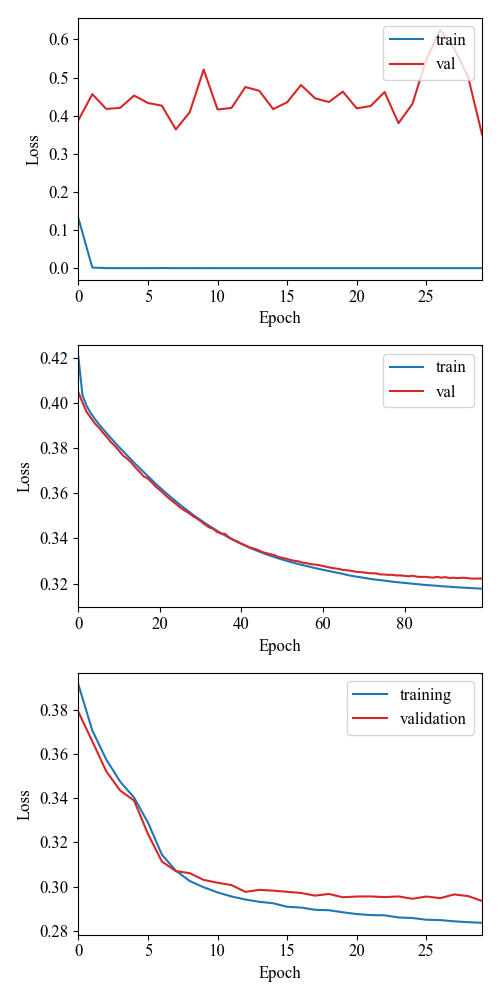

In [3]:
gomb_loss_history = np.load('/Users/austin/Documents/GitHub/GombNet/trained_models/TwoLeggedGraphene256.pthloss_history.npz')
gomb_train_loss = gomb_loss_history['train_loss_history']
gomb_val_loss = gomb_loss_history['val_loss_history']

unet_loss_history = np.load('/Users/austin/Documents/GitHub/GombNet/trained_models/BasicUNet256_nodrop.pthloss_history.npz')
unet_train_loss = unet_loss_history['train_loss_history']
unet_val_loss = unet_loss_history['val_loss_history']

unet_gomb_loss_history = np.load('/Users/austin/Documents/GitHub/GombNet/trained_models/BasicUNet256.pthloss_history.npz')
unet_gomb_train_loss = unet_gomb_loss_history['train_loss_history']
unet_gomb_val_loss = unet_gomb_loss_history['val_loss_history']

fig, axs = plt.subplots(3, 1, figsize=(5, 10))

axs[0].plot(unet_train_loss, label='train', color = '#1f77b4')
axs[0].plot(unet_val_loss, label='val', color = '#d62728')
axs[0].set_xlim(0, 29)

axs[1].plot(unet_gomb_train_loss, label='train', color = '#1f77b4')
axs[1].plot(unet_gomb_val_loss, label='val', color = '#d62728')
axs[1].set_xlim(0, 99)

axs[2].plot(gomb_train_loss, label='training', color = '#1f77b4')
axs[2].plot(gomb_val_loss, label='validation', color = '#d62728')
axs[2].set_xlim(0, 29)

for ax in axs:
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')

fig.tight_layout()
plt.savefig('loss_history', dpi=300)

In [4]:
# Create dataloaders
images_dir='/Users/austin/Desktop/G_dataset_256/images'
labels_dir='/Users/austin/Desktop/G_dataset_256/labels'
train_loader, val_loader, test_loader = get_dataloaders(images_dir, labels_dir, batch_size = 1, val_split=0.2, test_split=0.1)

Train size: 700, Validation size: 200, Test size: 100


In [5]:
def iou(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / union

def dice_coefficient(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    return 2 * intersection / (pred.sum() + gt.sum())

# Function to count the number of trainable parameters
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [6]:
# Random guessing benchmark
pwa_total = 0
dice_total = 0
IoU_total = 0

for i in range(len(test_loader)):
    gt = test_loader.dataset[i][1].numpy()  # Convert to numpy array
    
    # Random guessing
    prediction = np.random.randint(0, 2, gt.shape)

    pwa_original = np.sum(prediction == gt) / np.prod(gt.shape)
    dice_original = dice_coefficient(prediction, gt)
    iou_original = iou(prediction, gt)
    
    pwa_total += pwa_original
    dice_total += dice_original
    IoU_total += iou_original

pwa_total /= len(test_loader)
dice_total /= len(test_loader)
IoU_total /= len(test_loader)

acc_random = [pwa_total, dice_total, IoU_total]
print("Random")
print(f"Pixel-wise Accuracy: {pwa_total}")
print(f"Mean Dice Coefficient: {dice_total}")
print(f"Mean IoU: {IoU_total}")

Random
Pixel-wise Accuracy: 0.5002028656005859
Mean Dice Coefficient: 0.24304393338508604
Mean IoU: 0.13833415467449797


In [7]:
# Regular Unet Benchmark
input_channels = 1
num_classes = 2
num_filters = [32, 64, 128, 256]

model = Unet(input_channels, num_classes, num_filters, dropout = 0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = DiceLoss(alpha=2)

model_path = '/Users/austin/Documents/GitHub/GombNet/trained_models/BasicUNet256_nodrop.pth'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

pwa_total = 0
dice_total = 0
IoU_total = 0

# Calculate the accuracy
for i in range(len(test_loader)):
    test = test_loader.dataset[i][0].unsqueeze(0)
    gt = test_loader.dataset[i][1].numpy()  # Convert to numpy array
    
    with torch.no_grad():
        probability = model(test)
        prediction = torch.sigmoid(probability)  # Use torch.sigmoid instead of F.sigmoid (deprecated)
    
    probability = probability.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()

    threshold = threshold_otsu(prediction)
    prediction = (prediction > threshold).astype(float)
    
    # Calculate metrics for original and switched ground truths
    pwa_original = np.sum(prediction == gt) / np.prod(gt.shape)
    dice_original = dice_coefficient(prediction, gt)
    iou_original = iou(prediction, gt)
    
    # There is not combinatorial here
    pwa_total += pwa_original
    dice_total += dice_original
    IoU_total += iou_original

# Calculate the average for each metric
pwa_total /= len(test_loader)
dice_total /= len(test_loader)
IoU_total /= len(test_loader)

acc_UNet = [pwa_total, dice_total, IoU_total]

print("UNet")
print(f"Pixel-wise Accuracy: {pwa_total}")
print(f"Mean Dice Coefficient: {dice_total}")
print(f"Mean IoU: {IoU_total}")

# Get the number of trainable parameters
num_trainable_params = count_trainable_parameters(model)
print(f"Number of trainable parameters: {num_trainable_params}")

UNet
Pixel-wise Accuracy: 0.6305086517333984
Mean Dice Coefficient: 0.4273666098838183
Mean IoU: 0.2729063958349732
Number of trainable parameters: 1927874


In [8]:
# Regular Unet Benchmark
input_channels = 1
num_classes = 2
num_filters = [32, 64, 128, 256]

model = Unet(input_channels, num_classes, num_filters, dropout = 0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = DiceLoss(alpha=2)

model_path = '/Users/austin/Documents/GitHub/GombNet/trained_models/BasicUNet256.pth'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

pwa_total = 0
dice_total = 0
IoU_total = 0

# Calculate the accuracy
for i in range(len(test_loader)):
    test = test_loader.dataset[i][0].unsqueeze(0)
    gt = test_loader.dataset[i][1].numpy()  # Convert to numpy array
    
    with torch.no_grad():
        probability = model(test)
        prediction = torch.sigmoid(probability)  # Use torch.sigmoid instead of F.sigmoid (deprecated)
    
    probability = probability.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()

    threshold = threshold_otsu(prediction)
    prediction = (prediction > threshold).astype(float)
    
    # Calculate metrics for original and switched ground truths
    pwa_original = np.sum(prediction == gt) / np.prod(gt.shape)
    dice_original = dice_coefficient(prediction, gt)
    iou_original = iou(prediction, gt)
    
    # There is not combinatorial here
    pwa_total += pwa_original
    dice_total += dice_original
    IoU_total += iou_original

# Calculate the average for each metric
pwa_total /= len(test_loader)
dice_total /= len(test_loader)
IoU_total /= len(test_loader)

acc_UNet_gomb = [pwa_total, dice_total, IoU_total]

print("UNet w Gomb")
print(f"Pixel-wise Accuracy: {pwa_total}")
print(f"Mean Dice Coefficient: {dice_total}")
print(f"Mean IoU: {IoU_total}")

# Get the number of trainable parameters
num_trainable_params = count_trainable_parameters(model)
print(f"Number of trainable parameters: {num_trainable_params}")

UNet w Gomb
Pixel-wise Accuracy: 0.8564305877685547
Mean Dice Coefficient: 0.5608751404649728
Mean IoU: 0.39027372779271374
Number of trainable parameters: 1927874


In [9]:
# GombNet
input_channels = 1
num_classes = 2
num_filters = [32, 64, 128, 256]

model = TwoLeggedUnet(input_channels, num_classes, num_filters, dropout = 0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = GombinatorialLoss(group_size = num_classes//2, loss = 'Dice', epsilon=1e-6, class_weights = None, alpha=2)

model_path = '/Users/austin/Documents/GitHub/GombNet/trained_models/TwoLeggedGraphene256.pth'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

pwa_total = 0
dice_total = 0
IoU_total = 0

# Calculate the accuracy
for i in range(len(test_loader)):
    test = test_loader.dataset[i][0].unsqueeze(0)
    gt = test_loader.dataset[i][1].numpy()  # Convert to numpy array
    
    # Switch ground truth layers
    gt_switched = np.flip(gt, axis=0)
    
    with torch.no_grad():
        probability = model(test)
        prediction = torch.sigmoid(probability)  # Use torch.sigmoid instead of F.sigmoid (deprecated)
    
    probability = probability.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()

    threshold = threshold_otsu(prediction)
    prediction = (prediction > threshold).astype(float)
    
    # Calculate metrics for original and switched ground truths
    pwa_original = np.sum(prediction == gt) / np.prod(gt.shape)
    pwa_switched = np.sum(prediction == gt_switched) / np.prod(gt_switched.shape)
    
    dice_original = dice_coefficient(prediction, gt)
    dice_switched = dice_coefficient(prediction, gt_switched)
    
    iou_original = iou(prediction, gt)
    iou_switched = iou(prediction, gt_switched)
    
    # Take the highest value for each metric
    pwa_total += max(pwa_original, pwa_switched)
    dice_total += max(dice_original, dice_switched)
    IoU_total += max(iou_original, iou_switched)

# Calculate the average for each metric
pwa_total /= len(test_loader)
dice_total /= len(test_loader)
IoU_total /= len(test_loader)

acc_GombNet = [pwa_total, dice_total, IoU_total]

print("GombNet")
print(f"Pixel-wise Accuracy: {pwa_total}")
print(f"Mean Dice Coefficient: {dice_total}")
print(f"Mean IoU: {IoU_total}")

# Get the number of trainable parameters
num_trainable_params = count_trainable_parameters(model)
print(f"Number of trainable parameters: {num_trainable_params}")

GombNet
Pixel-wise Accuracy: 0.9522335815429688
Mean Dice Coefficient: 0.8458456283524977
Mean IoU: 0.736950318601053
Number of trainable parameters: 2682082


In [10]:
colors = ['#1f77b4', 'green', '#d62728', 'purple', '#ff7f0e']

In [11]:
colors = ['#1f77b4', 'green', '#d62728', 'purple', '#ff7f0e']

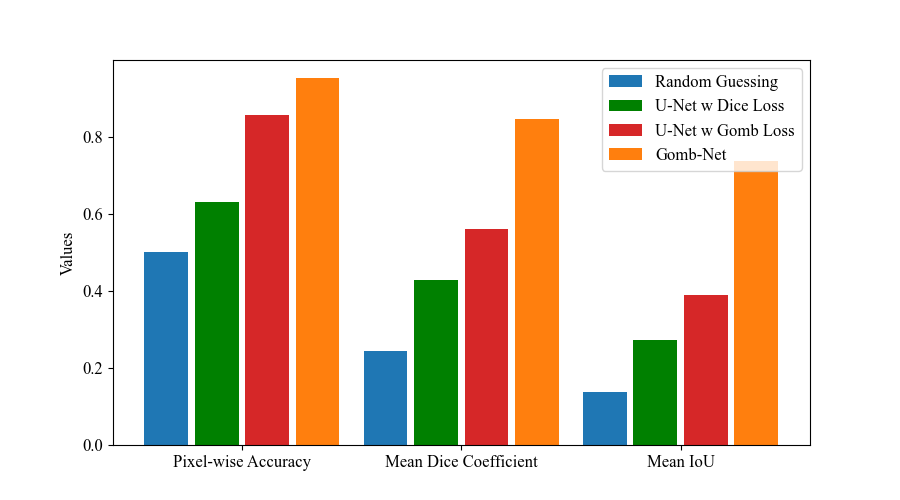

In [12]:
metrics = ['Pixel-wise Accuracy', 'Mean Dice Coefficient', 'Mean IoU']
bar_width = 0.2
space_between_bars = 0.03

index = np.arange(len(metrics))
fig, ax = plt.subplots(figsize=(9, 5))

# Adjusting the positions for uniform spacing
positions = [-1.5 * (bar_width + space_between_bars), 
             -0.5 * (bar_width + space_between_bars), 
              0.5 * (bar_width + space_between_bars), 
              1.5 * (bar_width + space_between_bars)]

# Plot bars for Random
bar1 = ax.bar(index + positions[0], acc_random, bar_width, label='Random Guessing', color='#1f77b4')

# Plot bars for UNet
bar2 = ax.bar(index + positions[1], acc_UNet, bar_width, label='U-Net w Dice Loss', color='green')

# Plot bars for UNet with Gomb loss
bar3 = ax.bar(index + positions[2], acc_UNet_gomb, bar_width, label='U-Net w Gomb Loss', color='#d62728')

# Plot bars for GombNet
bar4 = ax.bar(index + positions[3], acc_GombNet, bar_width, label='Gomb-Net', color='#ff7f0e')

# Add labels, title, and legend
ax.set_ylabel('Values')
ax.set_xticks(index)
ax.set_xticklabels(metrics)
ax.legend()

# Save and show the plot
plt.savefig('GombNet_vs_UNet.png', dpi=300)
plt.show()